In [1]:
import pandas as pd
import glob
import multiprocessing as mp
import bilby
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define new frequency domain source model 
bilby.core.utils.setup_logger(log_level='ERROR')
# Here we define out source model - this is the sine-Gaussian model in the
# frequency domain.
def lorentzian(frequency_array, amplitude, f0, gamma,inclination_angle):
    r"""
    Our custom source model which approximates a PMR peak frequency.
    This is just a lorentzian in frequency domain with a peak frequency f0 and a damping time quantity gamma.


    Parameters
    ----------
    frequency_array: array-like
        The frequencies to evaluate the model at. This is required for all
        Bilby source models.
    amplitude: float
        An overall amplitude prefactor.
    f0: float
        The central frequency.
    tau: float
        The damping rate.

    Returns
    -------
    dict:
        A dictionary containing "plus" and "cross" entries.

    """
    # Evaluate the lorentzian
    # Which version do we want to use? 
    arg2 = (amplitude**2.)/((frequency_array-f0)**2. + gamma**2.)
    arg = np.sqrt(arg2)
    # Take the real and complex parts for the plus and cross respectively 
    plus = 0.5*(1. + np.cos(inclination_angle)**2.)*arg2
    cross = - 1j*(np.cos(inclination_angle))*arg2
    return {"plus": plus, "cross": cross}



In [4]:
# Damped sinousid time domain
def time_domain_damped_sinusoid(time, amplitude, damping_time, frequency, phase, t0):
    r"""
    This example only creates a linearly polarised signal with only plus
    polarisation.

    .. math::

        h_{\plus}(t) =
            \Theta(t - t_{0}) A
            e^{-(t - t_{0}) / \tau}
            \sin \left( 2 \pi f t + \phi \right)

    Parameters
    ----------
    time: array-like
        The times at which to evaluate the model. This is required for all
        time-domain models.
    amplitude: float
        The peak amplitude.
    damping_time: float
        The damping time of the exponential.
    frequency: float
        The frequency of the oscillations.
    phase: float
        The initial phase of the signal.
    t0: float
        The offset of the start of the signal from the start time.

    Returns
    -------
    dict:
        A dictionary containing "plus" and "cross" entries.

    """
    plus = np.zeros(len(time))
    tidx = time >= t0
    plus[tidx] = (amplitude* np.exp(-(time[tidx] - t0) / damping_time)* np.sin(2 * np.pi * frequency * (time[tidx] - t0) + phase))
    cross = (amplitude* np.exp(-(time[tidx] - t0) / damping_time)* np.sin(2 * np.pi * frequency * (time[tidx] - t0) + phase+ np.pi/2))
    #print(plus)
    return {"plus": plus, "cross": cross}


# define parameters to inject.
injection_parameters = dict(
    amplitude=1e-22,
    damping_time=0.1,
    frequency=700,
    phase=0,
    ra=0,
    dec=0,
    psi=0,
    t0=0.0,
    geocent_time=0.0,
)



In [5]:
sampling_frequency = 16384 #4096
duration = 1



# # We now define some parameters that we will inject
# injection_parameters = dict(
#     amplitude=1e-2, f0=300, tau=1, phi0=0, geocent_time=0, ra=0, dec=0, psi=0,inclination_angle=0,gamma=100
# )


# Now we pass our source function to the WaveformGenerator
waveform_generator = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    time_domain_source_model=time_domain_damped_sinusoid,
    #frequency_domain_source_model=lorentzian,
)

# Set up interferometers.
ifos = bilby.gw.detector.InterferometerList(["CE", "CE"])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency,
    duration=duration,
    start_time=injection_parameters["geocent_time"] - 0.5,
)
ifos.inject_signal(
    waveform_generator=waveform_generator,
    parameters=injection_parameters,
    raise_error=False,
)



[{'plus': array([ 2.25985736e-26+0.00000000e+00j,  2.25986200e-26-1.47687674e-31j,
          2.25987592e-26-2.95378966e-31j, ...,
         -4.12076106e-28-9.82119549e-35j, -4.12076060e-28-4.91058929e-35j,
         -4.12076044e-28+0.00000000e+00j]),
  'cross': array([3.10362268e-27+0.00000000e+00j, 3.10362300e-27+3.26744403e-29j,
         3.10362394e-27+6.53492783e-29j, ...,
         3.05256752e-27-1.19162078e-30j, 3.05256752e-27-5.95810368e-31j,
         3.05256752e-27+0.00000000e+00j])},
 {'plus': array([ 2.25985736e-26+0.00000000e+00j,  2.25986200e-26-1.47687674e-31j,
          2.25987592e-26-2.95378966e-31j, ...,
         -4.12076106e-28-9.82119549e-35j, -4.12076060e-28-4.91058929e-35j,
         -4.12076044e-28+0.00000000e+00j]),
  'cross': array([3.10362268e-27+0.00000000e+00j, 3.10362300e-27+3.26744403e-29j,
         3.10362394e-27+6.53492783e-29j, ...,
         3.05256752e-27-1.19162078e-30j, 3.05256752e-27-5.95810368e-31j,
         3.05256752e-27+0.00000000e+00j])}]

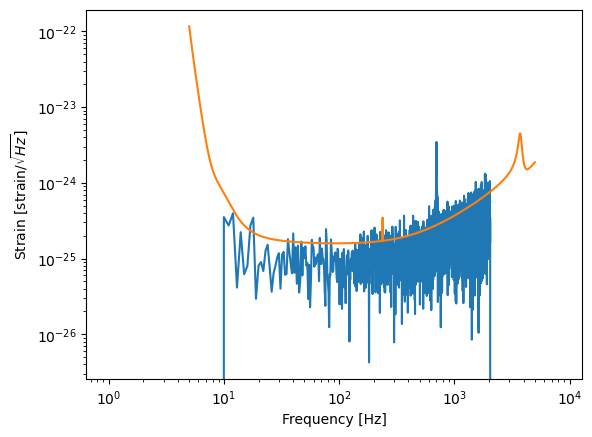

In [23]:
fig, ax = plt.subplots()
H1 = ifos[0]

#idxs = H1.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
ax.loglog(H1.strain_data.frequency_array,
          np.abs(H1.strain_data.frequency_domain_strain))
ax.loglog(H1.power_spectral_density.frequency_array,
          H1.power_spectral_density.asd_array)
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
#plt.xlim(650,1000)
plt.show()

[0.         0.01002004 0.02004008 0.03006012 0.04008016 0.0501002
 0.06012024 0.07014028 0.08016032 0.09018036 0.1002004  0.11022044
 0.12024048 0.13026052 0.14028056 0.1503006  0.16032064 0.17034068
 0.18036072 0.19038076 0.2004008  0.21042084 0.22044088 0.23046092
 0.24048096 0.250501   0.26052104 0.27054108 0.28056112 0.29058116
 0.3006012  0.31062124 0.32064128 0.33066132 0.34068136 0.3507014
 0.36072144 0.37074148 0.38076152 0.39078156 0.4008016  0.41082164
 0.42084168 0.43086172 0.44088176 0.4509018  0.46092184 0.47094188
 0.48096192 0.49098196 0.501002   0.51102204 0.52104208 0.53106212
 0.54108216 0.5511022  0.56112224 0.57114228 0.58116232 0.59118236
 0.6012024  0.61122244 0.62124248 0.63126253 0.64128257 0.65130261
 0.66132265 0.67134269 0.68136273 0.69138277 0.70140281 0.71142285
 0.72144289 0.73146293 0.74148297 0.75150301 0.76152305 0.77154309
 0.78156313 0.79158317 0.80160321 0.81162325 0.82164329 0.83166333
 0.84168337 0.85170341 0.86172345 0.87174349 0.88176353 0.891783

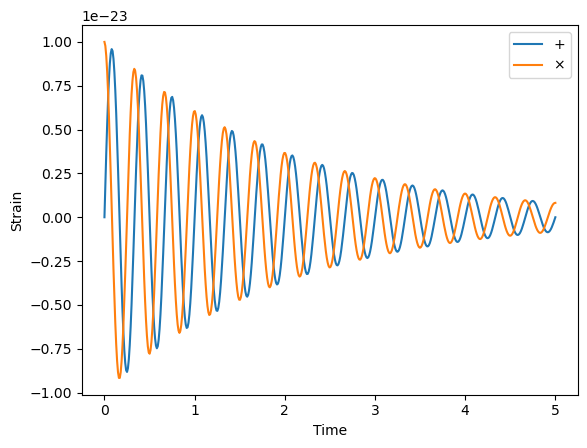

In [72]:
# Just generate and plot a raw lorentzian
amplitude=1e-23
# Still need to know what this value is!!!
damping_time=2
frequency=1500
phase=0
ra=0
dec=0
psi=0
t0=0.0
geocent_time=0.0
times = np.linspace(0,5,500)
print(times)
h = time_domain_damped_sinusoid(times, amplitude, damping_time, frequency, phase, t0)
print(h)
plt.plot(times,h["plus"],label=r'$+$')
plt.plot(times,h['cross'],label=r'$\times$')
plt.xlabel("Time")
plt.legend()
plt.ylabel("Strain")
plt.savefig("damped_sine.png",dpi=500)

In [8]:
# Read in the peak frequencies 
import pandas as pd
import glob
import multiprocessing as mp

def read_mass_freq_file(filepath):
    df = pd.read_csv(filepath, delim_whitespace=True, header=None, names=["mass_solar","radius km", "freq_khz"])
    df["source_file"] = filepath  # Add filename as identifier (optional)
    return df

# Collect all filenames
file_list_hot= glob.glob("/Users/smag0001/Downloads/f_peak_S_2_new/*.out")  # or adjust as needed
file_list = glob.glob("/Users/smag0001/Downloads/f_peak_T_0_new/*.out")
#print(file_list)

dfs = [read_mass_freq_file(f) for f in file_list]
dfs_hot = [read_mass_freq_file(f) for f in file_list_hot]
all_data = pd.concat(dfs, ignore_index=True)
all_data_hot = pd.concat(dfs_hot,ignore_index=True)
print(all_data)

       mass_solar  radius km  freq_khz  \
0        2.200000  16.716112  3.318129   
1        2.210000  16.702856  3.328729   
2        2.220000  16.689314  3.339416   
3        2.230000  16.675623  3.350153   
4        2.240000  16.661696  3.360966   
...           ...        ...       ...   
97952    2.900000  15.670855  4.128786   
97953    2.910000  15.598207  4.162577   
97954    2.920000  15.509372  4.202935   
97955    2.930000  15.387869  4.256584   
97956    2.939383  15.087150  4.383327   

                                             source_file  
0      /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
1      /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
2      /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
3      /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
4      /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
...                                                  ...  
97952  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
97953  /Users/smag0001/

In [9]:
# Randomly draw 100 PMR from the dataset and calculate peak frequency
# This probably 
n_PMR = 1000
PMR_samples = all_data_hot.sample(n=n_PMR) 
print(PMR_samples)

       mass_solar  radius km  freq_khz  \
91857        2.67  18.012264  3.271935   
68019        2.32  19.782432  2.698879   
5273         2.20  19.802483  2.631298   
84890        2.25  19.776802  2.662796   
82301        2.78  18.947635  3.108483   
...           ...        ...       ...   
37447        2.22  19.020532  2.790596   
19831        2.30  18.046653  3.047308   
57481        2.42  19.147688  2.875930   
19390        2.80  18.659935  3.185139   
26271        2.42  19.311768  2.842634   

                                             source_file  
91857  /Users/smag0001/Downloads/f_peak_S_2_new/f_pea...  
68019  /Users/smag0001/Downloads/f_peak_S_2_new/f_pea...  
5273   /Users/smag0001/Downloads/f_peak_S_2_new/f_pea...  
84890  /Users/smag0001/Downloads/f_peak_S_2_new/f_pea...  
82301  /Users/smag0001/Downloads/f_peak_S_2_new/f_pea...  
...                                                  ...  
37447  /Users/smag0001/Downloads/f_peak_S_2_new/f_pea...  
19831  /Users/smag0001/

In [ ]:
def inject_PMR_signal(f_peak,network_conf):

    print(f_peak)
    
    sampling_frequency = 16384 #4096
    duration = 20



    # # We now define some parameters that we will inject
    
    
    injection_parameters = dict(
        amplitude=1e-23,
        damping_time=3,
        frequency=f_peak,
        phase=0,
        ra=0,
        dec=0,
        psi=0,
        t0=0.0,
        geocent_time=0.0,
    )



    # Now we pass our source function to the WaveformGenerator
    waveform_generator = bilby.gw.waveform_generator.WaveformGenerator(
        duration=duration,
        sampling_frequency=sampling_frequency,
        time_domain_source_model=time_domain_damped_sinusoid,
    )

    # Set up interferometers.
    ifos = bilby.gw.detector.InterferometerList([network_conf[0], network_conf[1]])
    ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency,
    duration=duration,
    start_time=injection_parameters["geocent_time"] - 0.5,
    )
    ifos.inject_signal(
        waveform_generator=waveform_generator,
        parameters=injection_parameters,
        raise_error=False,
    )

    network_snr_sqr = 0.0 
    # Extract SNR 
    for ifo in ifos:
        if hasattr(ifo, 'meta_data') and 'optimal_SNR' in ifo.meta_data:
            optimal_snr = ifo.meta_data['optimal_SNR']
            network_snr_sqr += optimal_snr**2.
    network_snr = np.sqrt(network_snr_sqr)
    
    return network_snr 

print(inject_PMR_signal(1500,["CE","CE"]))

In [ ]:
def get_SNRs_from_network_conf(PMR_samples,network_conf):

    print(PMR_samples)
    SNRs = inject_PMR_signal(PMR_samples['freq_khz'],network_conf)
    


    return SNRs

get_SNRs_from_network_conf(PMR_samples,["CE","CE"])

In [63]:
import numpy as np
import pandas as pd
import bilby
from concurrent.futures import ThreadPoolExecutor
import multiprocessing as mp

def inject_PMR_signal_vectorized(f_peaks, network_conf, n_jobs=None):
    """
    Vectorized version to inject PMR signals for multiple frequencies
    
    Parameters:
    -----------
    f_peaks : array-like
        Array of frequencies in Hz
    network_conf : list
        Network configuration for interferometers
    n_jobs : int, optional
        Number of parallel jobs. If None, uses all available CPUs
    
    Returns:
    --------
    numpy.array : Array of network SNRs
    """
    f_peaks = np.array(f_peaks)
    
    # Set up parameters that don't change
    sampling_frequency = 16384
    duration = 20
    # Ra and dec - sky position is changed randomly
    np.random.seed(42) # This is a HACK FIX!!! we want the binaries to all be the same so we set a seed. 
    ra = np.random.uniform(0, 2 * np.pi)  # Right ascension: 0 to 2π
    dec = np.random.uniform(-np.pi/2, np.pi/2)  # Declination: -π/2 to π/2
    # Base injection parameters
    base_injection_parameters = dict(
        amplitude=5e-22,
        damping_time=0.2,
        phase=0,
        ra=ra,
        dec=dec,
        psi=0,
        t0=0.0,
        geocent_time=0.0,
    )
    
    # Set up waveform generator (assuming you have time_domain_damped_sinusoid defined)
    waveform_generator = bilby.gw.waveform_generator.WaveformGenerator(
        duration=duration,
        sampling_frequency=sampling_frequency,
        time_domain_source_model=time_domain_damped_sinusoid,
    )
    
    def calculate_snr_batch(f_peaks_batch):
        """Calculate SNR for a batch of frequencies"""
        network_snrs = []
        
        for f_peak in f_peaks_batch:
            # Update injection parameters
            injection_parameters = base_injection_parameters.copy()
            injection_parameters['frequency'] = f_peak
            
            # Set up interferometers
            ifos = bilby.gw.detector.InterferometerList([network_conf[0], network_conf[1]])
            ifos.set_strain_data_from_power_spectral_densities(
                sampling_frequency=sampling_frequency,
                duration=duration,
                start_time=injection_parameters["geocent_time"] - 0.5,
            )
            
            # Inject signal
            ifos.inject_signal(
                waveform_generator=waveform_generator,
                parameters=injection_parameters,
                raise_error=False,
            )
            
            # Calculate network SNR
            network_snr_sqr = 0.0
            for ifo in ifos:
                if hasattr(ifo, 'meta_data') and 'optimal_SNR' in ifo.meta_data:
                    optimal_snr = ifo.meta_data['optimal_SNR']
                    network_snr_sqr += optimal_snr**2.0
            
            network_snr = np.sqrt(network_snr_sqr)
            network_snrs.append(network_snr)
        
        return network_snrs
    
    # Single-threaded for small datasets, parallel for large ones
    if len(f_peaks) < 100:
        network_snrs = calculate_snr_batch(f_peaks)
    else:
        # Parallel processing for large datasets
        if n_jobs is None:
            n_jobs = mp.cpu_count()
        
        # Split f_peaks into chunks
        chunk_size = max(1, len(f_peaks) // n_jobs)
        f_peaks_chunks = [f_peaks[i:i + chunk_size] for i in range(0, len(f_peaks), chunk_size)]
        
        # Process chunks in parallel
        with ThreadPoolExecutor(max_workers=n_jobs) as executor:
            chunk_results = list(executor.map(calculate_snr_batch, f_peaks_chunks))
        
        # Flatten results
        network_snrs = [snr for chunk_result in chunk_results for snr in chunk_result]
    
    return np.array(network_snrs)

def get_SNRs_from_network_conf(PMR_samples, network_conf):
    """
    Get SNRs from network configuration using vectorized injection
    
    Parameters:
    -----------
    PMR_samples : pandas.DataFrame
        DataFrame containing 'freq_khz' column with frequencies
    network_conf : list
        Network configuration for interferometers
    
    Returns:
    --------
    numpy.array : Array of network SNRs
    """
    print(PMR_samples)
    
    # Convert freq_khz to Hz
    freq_hz = PMR_samples['freq_khz'] * 1000
    
    # Get SNRs using vectorized function
    SNRs = inject_PMR_signal_vectorized(freq_hz, network_conf)
    
    return SNRs

In [64]:
SNRs = get_SNRs_from_network_conf(PMR_samples,["NEMO","CE"])
SNRs_CE_het = get_SNRs_from_network_conf(PMR_samples,["CE","CE"])

       mass_solar  radius km  freq_khz  \
36503        2.48  16.792068  3.485029   
72194        2.88  17.403363  3.553949   
6213         2.53  15.166029  4.055441   
95553        2.42  16.519987  3.524832   
30919        2.77  16.974715  3.613604   
...           ...        ...       ...   
46401        2.58  15.823153  3.856382   
38981        2.82  15.781214  4.035047   
71084        2.22  15.354164  3.749992   
96759        2.54  16.361817  3.653507   
93181        2.45  17.130714  3.370804   

                                             source_file  
36503  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
72194  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
6213   /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
95553  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
30919  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
...                                                  ...  
46401  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
38981  /Users/smag0001/

In [65]:
SNRs_CE_ET = get_SNRs_from_network_conf(PMR_samples,["CE","ET"])
SNRs_CE_ET_NEMO = get_SNRs_from_network_conf(PMR_samples,["CE","ET","NEMO"])
SNRs_CE_ET_NEMO_A1 = get_SNRs_from_network_conf(PMR_samples,["CE","ET","NEMO","A1"])

       mass_solar  radius km  freq_khz  \
36503        2.48  16.792068  3.485029   
72194        2.88  17.403363  3.553949   
6213         2.53  15.166029  4.055441   
95553        2.42  16.519987  3.524832   
30919        2.77  16.974715  3.613604   
...           ...        ...       ...   
46401        2.58  15.823153  3.856382   
38981        2.82  15.781214  4.035047   
71084        2.22  15.354164  3.749992   
96759        2.54  16.361817  3.653507   
93181        2.45  17.130714  3.370804   

                                             source_file  
36503  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
72194  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
6213   /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
95553  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
30919  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
...                                                  ...  
46401  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
38981  /Users/smag0001/

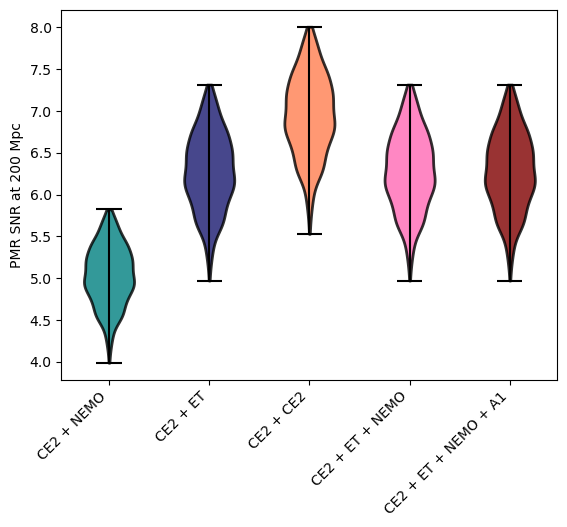

In [73]:
colors = ['teal','midnightblue','coral','hotpink','maroon']
edge_color= 'black'
parts = plt.violinplot([SNRs,SNRs_CE_ET,SNRs_CE_het,SNRs_CE_ET_NEMO,SNRs_CE_ET_NEMO_A1])
for pc, color in zip(parts['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_edgecolor(edge_color)  # Match the error bar color
    pc.set_linewidth(2)
    pc.set_alpha(0.8)

# Set error bars to match edge color
parts['cmins'].set_color(edge_color)
parts['cmaxes'].set_color(edge_color)
parts['cbars'].set_color(edge_color)
#parts['cmedians'].set_color(edge_color)
# Long labels
labels = ['CE2 + NEMO', 'CE2 + ET', 'CE2 + CE2', 'CE2 + ET + NEMO','CE2 + ET + NEMO + A1']
plt.xticks(range(1, len(labels) + 1), labels, rotation=45, ha='right')
plt.ylabel('PMR SNR at 200 Mpc')
#plt.savefig('SNR_violinplot.pdf',bbox_inches='tight')
plt.savefig('SNR_violinplot.png',dpi=500,bbox_inches='tight')

In [30]:
# The same thing but for cold EOSs
# Randomly draw 100 PMR from the dataset and calculate peak frequency
# This probably 
n_PMR = 1000
PMR_samples = all_data.sample(n=n_PMR) 
print(PMR_samples)

       mass_solar  radius km  freq_khz  \
36503        2.48  16.792068  3.485029   
72194        2.88  17.403363  3.553949   
6213         2.53  15.166029  4.055441   
95553        2.42  16.519987  3.524832   
30919        2.77  16.974715  3.613604   
...           ...        ...       ...   
46401        2.58  15.823153  3.856382   
38981        2.82  15.781214  4.035047   
71084        2.22  15.354164  3.749992   
96759        2.54  16.361817  3.653507   
93181        2.45  17.130714  3.370804   

                                             source_file  
36503  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
72194  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
6213   /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
95553  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
30919  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
...                                                  ...  
46401  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
38981  /Users/smag0001/

In [31]:
SNRs = get_SNRs_from_network_conf(PMR_samples,["NEMO","CE"])
SNRs_CE_het = get_SNRs_from_network_conf(PMR_samples,["CE","CE"])
SNRs_CE_ET = get_SNRs_from_network_conf(PMR_samples,["CE","ET"])
SNRs_CE_ET_NEMO = get_SNRs_from_network_conf(PMR_samples,["CE","ET","NEMO"])
SNRs_CE_ET_NEMO_A1 = get_SNRs_from_network_conf(PMR_samples,["CE","ET","NEMO","A1"])

       mass_solar  radius km  freq_khz  \
36503        2.48  16.792068  3.485029   
72194        2.88  17.403363  3.553949   
6213         2.53  15.166029  4.055441   
95553        2.42  16.519987  3.524832   
30919        2.77  16.974715  3.613604   
...           ...        ...       ...   
46401        2.58  15.823153  3.856382   
38981        2.82  15.781214  4.035047   
71084        2.22  15.354164  3.749992   
96759        2.54  16.361817  3.653507   
93181        2.45  17.130714  3.370804   

                                             source_file  
36503  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
72194  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
6213   /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
95553  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
30919  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
...                                                  ...  
46401  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
38981  /Users/smag0001/

{'bodies': [<matplotlib.collections.PolyCollection at 0x7fa420e147f0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7fa433616a40>,
 'cmins': <matplotlib.collections.LineCollection at 0x7fa43363bd00>,
 'cbars': <matplotlib.collections.LineCollection at 0x7fa433624460>}

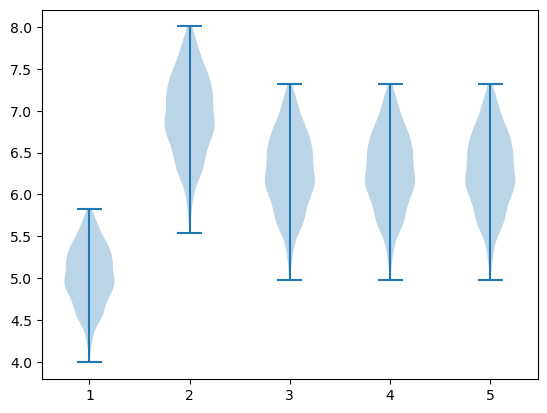

In [33]:
plt.violinplot([SNRs,SNRs_CE_het,SNRs_CE_ET,SNRs_CE_ET_NEMO,SNRs_CE_ET_NEMO_A1])